$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 3: Convolutional Architectures
<a id=part3></a>

In this part we will explore convolution networks and the effects of their architecture on accuracy. We'll implement a common block-based deep CNN pattern and we'll perform various experiments on it while varying the architecture. Then we'll implement our own custom architecture to see whether we can get high classification results on a large subset of CIFAR-10.

Training will be performed on GPU.

In [7]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

## Convolutional layers and networks
<a id=part3_1></a>

Convolutional layers are the most essential building blocks of the state of the art deep learning image classification models and also play an important role in many other tasks.
As we saw in the tutorial, convolutional layers operate on and produce volumes (3D tensors) of activations.


One way to think about them is as if the neurons are organized in a 3D grid,
where neurons at the same depth share weights (represented here as colors).
Contrary to fully connected (affine) layers, neurons in convolutional layers are **not** connected to each of the activations of the previous layer.
Instead, each neuron is connected only to a small region of the input volume e.g. a 5x5x$C_{\mathrm{in}}$ slice
(where $C_{\mathrm{in}}$ is the input volume's depth).

<img src="imgs/depthcol.jpeg" />

Another way to interpret convolutional layers is as a collection of 3D learnable filters,
each of which operates on a small spatial region of the input volume.
Each filter is convolved with the input volume ("slides over it"),
and a dot product is computed at each location followed by a non-linearity which produces one activation.
All these activations produce a 2D plane known as a **feature map**.
Multiple feature maps (one for each filter) comprise the output volume.

<img src="imgs/cnn_filters.png" width="600" />

A crucial property of convolutional layers is their translation invariance,
i.e. their ability to detect features regardelss of their spatial location in the input.

Convolutional network architectures usually follow a pattern basic repeating blocks: one or more convolution layers, each followed by a non-linearity (generally ReLU) and then a pooling layer to reduce spatial dimensions. Usually, the number of convolutional filters increases the deeper they are in the network.
These layers are meant to extract features from the input.
Then, one or more fully-connected layers is used to combine the extracted features into the required number of output class scores.

## Building convolutional networks with PyTorch
<a id=part3_2></a>

PyTorch provides all the basic building blocks needed for creating a convolutional arcitecture within the [`torch.nn`](https://pytorch.org/docs/stable/nn.html) package.
Let's use them to create a basic convolutional network with the following architecture pattern:

    [(CONV -> ReLU)*P -> MaxPool]*(N/P) -> (Linear -> ReLU)*M -> Linear

Here $N$ is the total number of convolutional layers,
$P$ specifies how many convolutions to perform before each pooling layer
and $M$ specifies the number of hidden fully-connected layers before the final output layer.

**TODO**: Complete the implementaion of the `ConvClassifier` class in the `hw2/models.py` module.

In [2]:
import hw2.models as models
torch.manual_seed(seed)

net = models.ConvClassifier((3,100,100), 10, filters=[32]*4, pool_every=2, hidden_dims=[100]*2).to(device)
print(net)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100)).to(device)
test_out = net(test_image.unsqueeze(0))
print('out =', test_out)

expected_out = torch.load('tests/assets/expected_conv_out.pt').to(device)
test.assertLess(torch.norm(test_out - expected_out).item(), 1e-5)

ConvClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=20000, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
out = tensor([[-0.0868, -0.3790, -0.4341, -0.1236, -0.2160,  0.1683,  0.4739,  0.0750,
          0.1151, -0.1606]], device='cuda:0', grad_fn=

**Note about running on GPUs**: Notice how we called `.to(device)` on **both** the model and the input tensor.
Here the `device` is a `torch.device` object that we created above. If an nvidia GPU is available on the machine you're running this on, the `device` will be `'cuda'`. When you run `.to(device)` on a model, it recursively goes over all the model parameter tensors and copies their memory to the GPU. Similarly, calling `.to(device)` on the input image also copies it. In order to train on a GPU, you need to make sure to move **all** your tensors to it. You'll get errors if you try to mix CPU and GPU tensors in a computation.

In [3]:
print(f'This notebook is running with device={device}')
print(f'The model parameter tensors are therefore also on device={next(net.parameters()).device}')
print(f'The test image is therefore also on device={test_image.device}')

This notebook is running with device=cuda
The model parameter tensors are therefore also on device=cuda:0
The test image is therefore also on device=cuda:0


Let's load CIFAR-10 again to use as our dataset.

In [4]:
#data_dir = os.path.join(os.getenv('HOME'), '.pytorch-datasets')
data_dir = os.path.join(r"C:\Studies\Master's\Courses\Deep Learning on Accelerators - 236605", '.pytorch-datasets')
ds_train = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=tvtf.ToTensor())
ds_test = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=tvtf.ToTensor())

print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')

x0,_ = ds_train[0]
in_size = x0.shape
num_classes = 10
print('input image size =', in_size)

Files already downloaded and verified
Files already downloaded and verified
Train: 50000 samples
Test: 10000 samples
input image size = torch.Size([3, 32, 32])


Now as usual, as a sanity test let's make sure we can overfit a tiny dataset with our model. But first we need to adapt our `Trainer` for PyTorch models.

**TODO**: Complete the implementaion of the `TorchTrainer` class in the `hw2/training.py` module.

In [5]:
import hw2.training as training
torch.manual_seed(seed)

# Define a tiny part of the CIFAR-10 dataset to overfit it
batch_size = 2
max_batches = 25
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)

# Create model, loss and optimizer instances
model = models.ConvClassifier(in_size, num_classes, filters=[32], pool_every=1, hidden_dims=[100])
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9,)

# Use TorchTrainer to run only the training loop a few times.
trainer = training.TorchTrainer(model, loss_fn, optimizer, device)
best_acc = 0
for i in range(22):
    res = trainer.train_epoch(dl_train, max_batches=max_batches, verbose=(i%2==0))
    best_acc = res.accuracy if res.accuracy > best_acc else best_acc
    
# Test overfitting
test.assertGreaterEqual(best_acc, 95)

train_batch (Avg. Loss 0.001, Accuracy 100.0): 100%|██████████| 25/25 [00:00<00:00, 173.85it/s]


## Experimenting with model architectures
<a id=part3_3></a>

You will now perform a series of experiments that train various model configurations on a much larger part of the CIFAR-10 dataset.

To perform the experiments, you'll need to use a machine with a GPU since training time might be too long otherwise.


### Notes on using course servers

First, please read the [course servers guide](https://vistalab-technion.github.io/cs236605/assignments/hpc-servers/) carefully.

To run the experiments on the course servers, you can use the `py-sbatch.sh` script directly to perform a single experiment run in batch mode (since it runs python once), or use the `srun` command to do a single run in interactive mode. For example, running a single run of experiment 1 interactively (after `conda activate` of course):

```shell
srun -c 2 --gres=gpu:1 --pty python -m hw2.experiments run-exp -n test -K 32 64 -L 2 -P 2 -H 100
```

To perform multiple runs in batch mode with `sbatch` (e.g. for running all the configurations of an experiments), you can create your own script based on `py-sbatch.sh` and invoke whatever commands you need within it.

Please don't request more than **2 CPU** cores and **1 GPU** device for your runs. The code won't be able to utilize more than that anyway, so you'll see no performance gain if you do. It will only cause delays for other students using the servers.

### General notes for running experiments

- You can run the experiments on a different machine (e.g. the course servers) and copy the results (files)
to the `results` folder on your local machine.
This notebook will only display the results, not run the actual experiment code (except for a demo run).

- It's important to give each experiment run a name as specified by the notebook instructions later on. The each run has a `run_name` parameter that will also be the name of the results file which this notebook will expect to load.

- You will implement the code to run the experiments in the `hw2/experiments.py` module. This module has a CLI parser so that you can invoke it as a script and pass in all the configuration parameters for a single experiment run.

- You should use `python -m hw2.experiments run-exp` to run an experiment, and **not** `python hw2/experiments.py run-exp`, regardless of how/where you run it.

### Experiment 1 - Network depth and number of filters

In this part we will test some different architecture configurations based on our `ConvClassifier`.
Specifically, we want to try different depths and number of features to see the effects these parameters have on the model's performance.

To do this, we'll define two extra hyperparameters for our model, `K` (`filters_per_layer`) and `L` (`layers_per_block`).
- `K` is a list, containing the number of filters we want to have in our conv layers.
- `L` is the number of consecutive layers with the same number of filters to use.

For example, if `K=[32, 64]` and `L=2` it means we want two conv layers with 32 filters followed by two conv layers with 64 filters. The feature-extraction part of our model will therefore be:

    Conv(X,32)->ReLu->Conv(32,32)->ReLU->MaxPool->Conv(32,64)->ReLU->Conv(64,64)->ReLU->MaxPool
    
We'll try various values of the `K` and `L` parameters in combination and see how each architecture trains. **All other hyperparameters are up to you**, including the choice of the optimization algorithm, the learning rate, regularization and architecture hyperparams such as `pad_every` and `hidden_dims`. You can try some manual runs to determine some good values for the hyperparameters or implement cross-validation to do it.
However, the **dataset size** you test on should be large. Use at least ~12000 training images and ~3000 validation images. The **batch size** parameter however is also up to you.

The important thing is that you state what you used, how you decided on it, and explain your results based on that.

First we need to write some code to run the experiment.

**TODO**:
1. Implement the `run_experiment()` function in the `hw2/experiments.py` module.
1. If you haven't done so already, it would be an excellent idea to implement the **early stopping** feature of the `Trainer` class.

The following block tests that your implementation works. It's also meant to show you that each experiment run creates a result file containing the parameters to reproduce and the `FitResult` object for plotting.

Files already downloaded and verified
Files already downloaded and verified
--- EPOCH 1/10 ---
test_batch (Avg. Loss 1.064, Accuracy 65.2): 100%|██████████| 834/834 [00:03<00:00, 216.41it/s]
--- EPOCH 10/10 ---
test_batch (Avg. Loss 1.110, Accuracy 64.6): 100%|██████████| 834/834 [00:03<00:00, 227.79it/s]
Finished Training
*** Output file ./results/test_run.json written
experiment config:  {'run_name': 'test_run', 'out_dir': './results', 'seed': 42, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 1, 'hidden_dims': [100], 'ycn': False, 'kw': {}, 'filters_per_layer': [32], 'layers_per_block': 1}


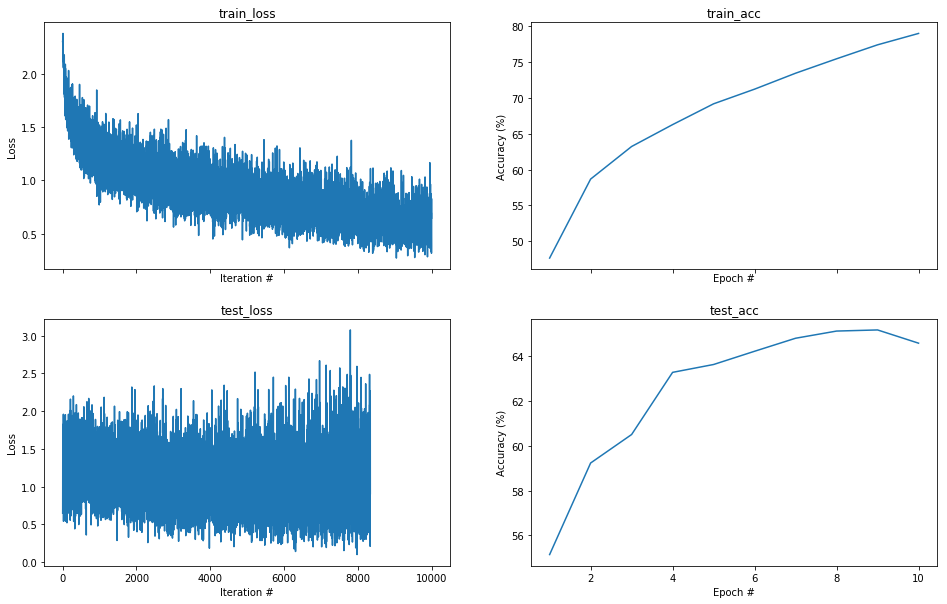

In [6]:
import hw2.experiments as experiments
from hw2.experiments import load_experiment
from cs236605.plot import plot_fit

# Test experiment1 implementation on a few data samples and with a small model
experiments.run_experiment('test_run', seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
                           filters_per_layer=[32], layers_per_block=1, pool_every=1, hidden_dims=[100])

# There should now be a file 'test_run.json' in your `results/` folder.
# We can use it to load the results of the experiment.
cfg, fit_res = load_experiment('results/test_run.json')
_, _ = plot_fit(fit_res)

# And `cfg` contains the exact parameters to reproduce it
print('experiment config: ', cfg)

We'll use the following function to load multiple experiment results and plot them together.

In [7]:
def plot_exp_results(filename_pattern, results_dir='results'):
    fig = None
    result_files = glob.glob(os.path.join(results_dir, filename_pattern))
    result_files.sort()
    if len(result_files) == 0:
        print(f'No results found for pattern {filename_pattern}.', file=sys.stderr)
        return
    for filepath in result_files:
        m = re.match('exp\d_(\d_)?(.*)\.json', os.path.basename(filepath))
        cfg, fit_res = load_experiment(filepath)
        fig, axes = plot_fit(fit_res, fig, legend=m[2],log_loss=True)
    del cfg['filters_per_layer']
    del cfg['layers_per_block']
    print('common config: ', cfg)

#### Experiment 1.1: Varying the network depth (`L`)

First, we'll test the effect of the network depth on training.

**Configuratons**:
- `K=32` fixed, with `L=2,4,8,16` varying per run
- `K=64` fixed, with `L=2,4,8,16` varying per run

So 8 different runs in total.

**Naming runs**:
Each run should be named `exp1_1_K{}_L{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_1_K32_L2`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_1_K32_L8', 'out_dir': './results', 'seed': 657856571, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 20, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 2, 'hidden_dims': [1024], 'ycn': False, 'kw': {}}


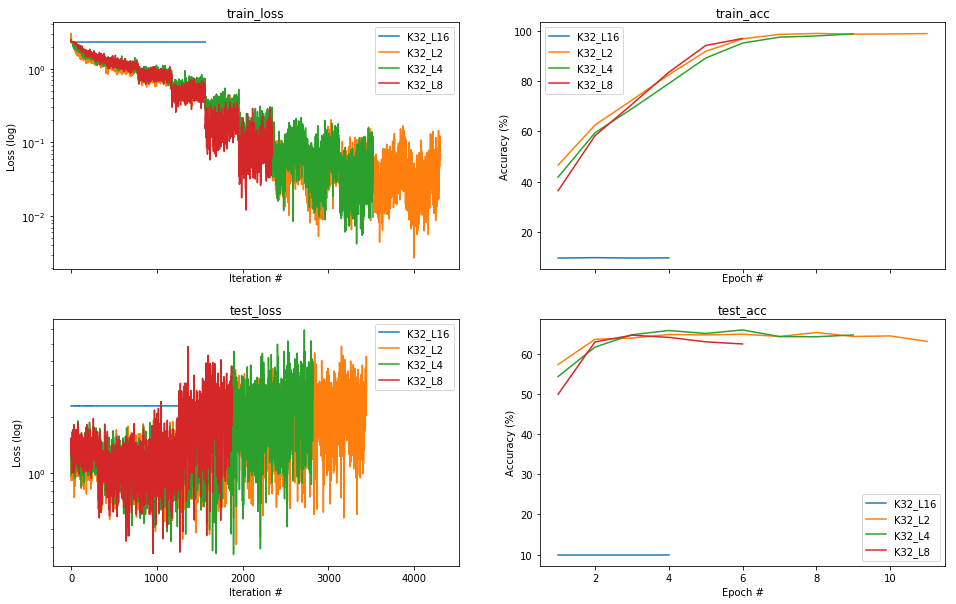

In [8]:
plot_exp_results('exp1_1_K32*.json')

common config:  {'run_name': 'exp1_1_K64_L8', 'out_dir': './results', 'seed': 963393219, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 20, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 2, 'hidden_dims': [1024], 'ycn': False, 'kw': {}}


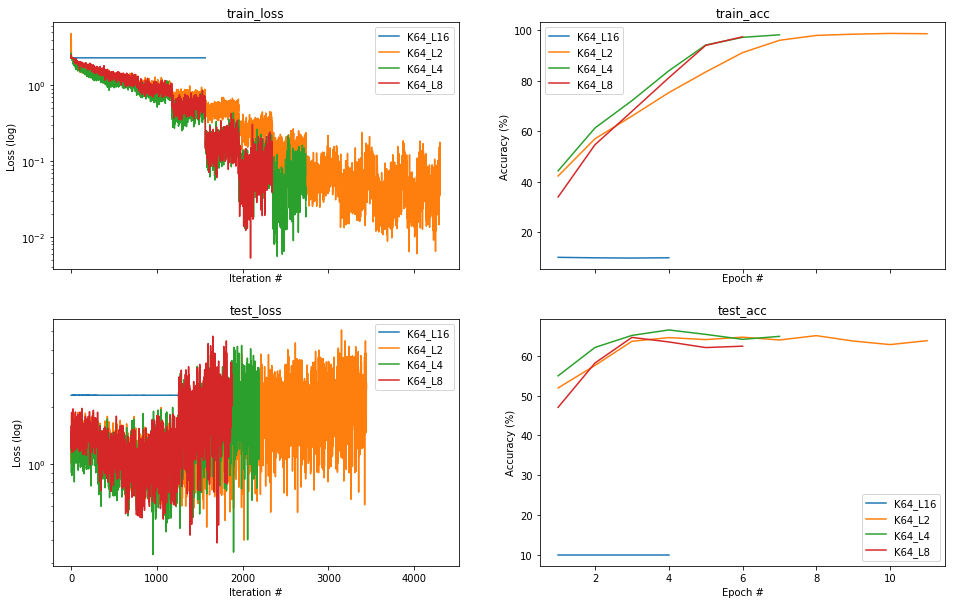

In [9]:
plot_exp_results('exp1_1_K64*.json')

#### Experiment 1.2: Varying the number of filters per layer (`K`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `L=2` fixed, with `K=[32],[64],[128],[258]` varying per run.
- `L=4` fixed, with `K=[32],[64],[128],[258]` varying per run.
- `L=8` fixed, with `K=[32],[64],[128],[258]` varying per run.

So 12 different runs in total. To clarify, each run `K` takes the value of a list with a single element.

**Naming runs**:
Each run should be named `exp1_2_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_2_L2_K32`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_2_L2_K64', 'out_dir': './results', 'seed': 53373283, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 20, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 2, 'hidden_dims': [1024], 'ycn': False, 'kw': {}}


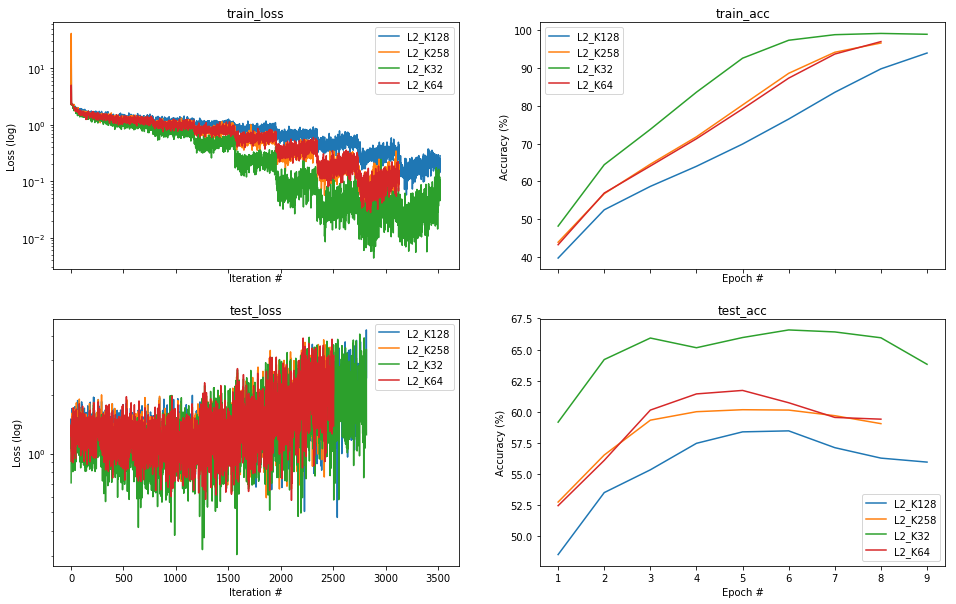

In [10]:
plot_exp_results('exp1_2_L2*.json')

common config:  {'run_name': 'exp1_2_L4_K64', 'out_dir': './results', 'seed': 509638249, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 20, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 2, 'hidden_dims': [1024], 'ycn': False, 'kw': {}}


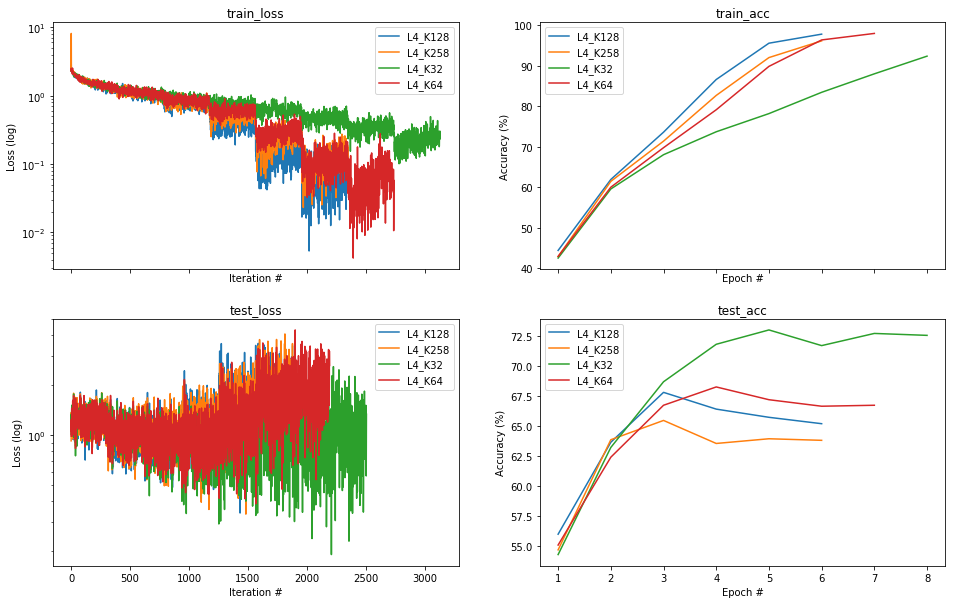

In [11]:
plot_exp_results('exp1_2_L4*.json')

common config:  {'run_name': 'exp1_2_L8_K64', 'out_dir': './results', 'seed': 1258519166, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 20, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 2, 'hidden_dims': [1024], 'ycn': False, 'kw': {}}


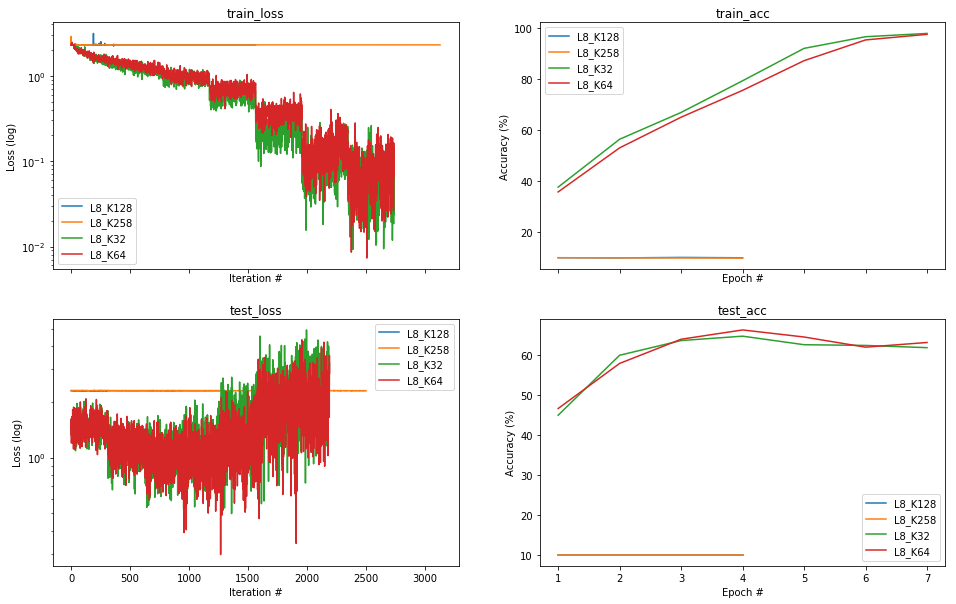

In [12]:
plot_exp_results('exp1_2_L8*.json')

#### Experiment 1.3: Varying both the number of filters (`K`) and network depth (`L`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `K=[64, 128, 256]` fixed with `L=1,2,3,4` varying per run.

So 4 different runs in total. To clarify, each run `K` takes the value of an array with a three elements.

**Naming runs**:
Each run should be named `exp1_3_L{}_K{}-{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_3_L1_K64-128-256`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_3_L4_K64-128-256', 'out_dir': './results', 'seed': 1302093639, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 20, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 2, 'hidden_dims': [1024], 'ycn': False, 'kw': {}}


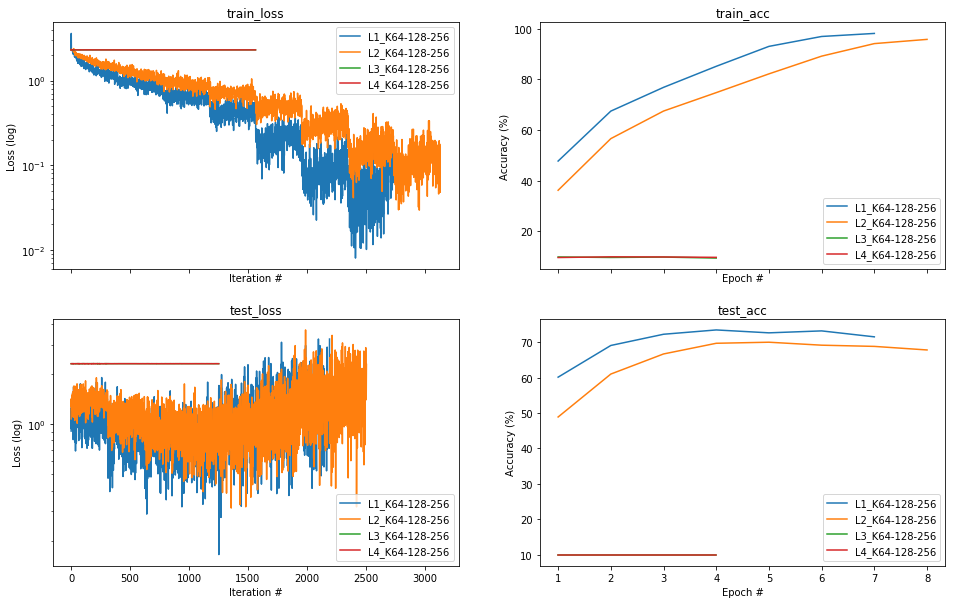

In [13]:
plot_exp_results('exp1_3*.json')

### Experiment 2 - Custom network architecture

In this part you will create your own custom network architecture based on the `ConvClassifier` you've implemented.

Try to overcome some of the limitations your experiment 1 results, using what you learned in the course.

You are free to add whatever you like to the model, for instance 
- Batch normalization
- Dropout layers
- Skip connections
- Change kernel spatial sizes and strides
- Custom blocks or ideas from known architectures

Just make sure to keep the model's `init` API identical (or maybe just add parameters).

**TODO**: Implement your custom architecture in the `YourCodeNet` class within the `hw2/models.py` module.

In [14]:
net = models.YourCodeNet((3,100,100), 10, filters=[32]*4, pool_every=2, hidden_dims=[100]*2).to(device)
print(net)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100)).to(device)
test_out = net(test_image.unsqueeze(0))
print('out =', test_out)

YourCodeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2)
    (4): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout2d(p=0.2)
    (8): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout2d(p=0.2)
    (13): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Dropout2d(p=0.2)
    (17): MaxPool2d(kernel_s

#### Experiment 2 Configuration

Run your custom model on at least the following:

**Configuratons**:
- `K=[64, 128, 256, 512]` fixed with `L=1,2,3,4` varying per run.

So 4 different runs in total. To clarify, each run `K` takes the value of an array with a four elements.

If you want, you can add some extra following the same pattern.
Try to see how deep a model you can train.

**Naming runs**:
Each run should be named `exp2_L{}_K{}-{}-{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp2_L1_K64-128-256-512`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results. To make the experiment runner use your custom network model instead of the previous one, use the `--ycn` argument on the command line.

common config:  {'run_name': 'exp2_L4_K64-128-256-512', 'out_dir': './results', 'seed': 2086142939, 'bs_train': 128, 'bs_test': 32, 'batches': 100, 'epochs': 20, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 2, 'hidden_dims': [1024], 'ycn': True, 'kw': {}}


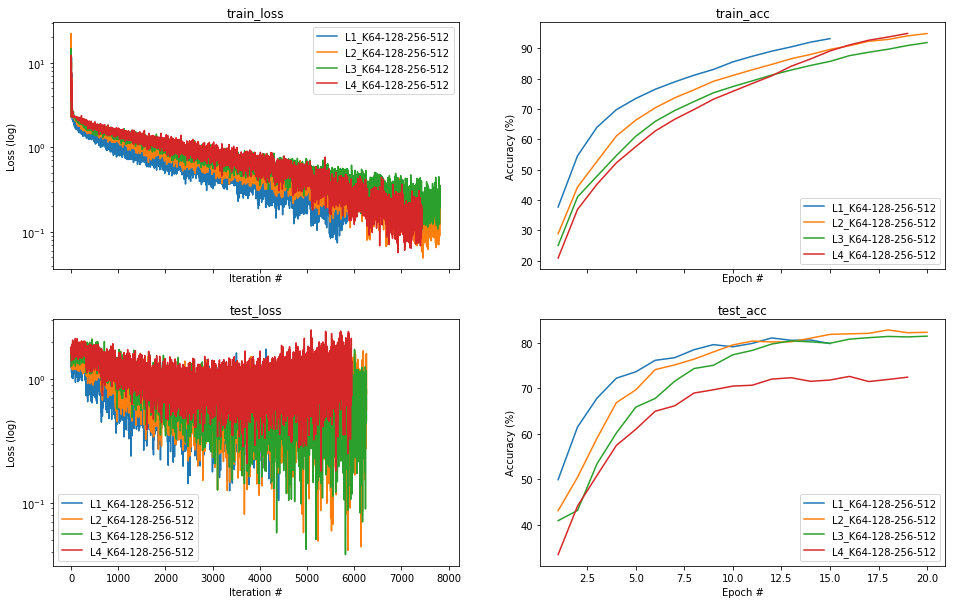

In [15]:
plot_exp_results('exp2*.json')

## Questions
<a id=part3_4></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw2/answers.py`.

In [1]:
from cs236605.answers import display_answer
import hw2.answers

### Question 1 

Analyze your results from experiment 1.1. In particular,
1.  Explain the effect of depth on the accuracy. What depth produces the best results and why do you think that's the case?
1. Were there values of `L` for which the network wasn't trainable? what causes this? Suggest two things which may be done to resolve it at least partially.

In [2]:
display_answer(hw2.answers.part3_q1)


Our basic expectation is that, the deeper the network, the richer representations it can learn, which should translate to better
results.

However, in experiment 1.1, we can see that the best accuracy score was for L=4 and L=2, while L=8 has scored significantly lower, and
the training with L=16 was completely unsuccessful, with L=4 being just slightly better then L=2.

Those findings are true both in the case of K=32, and for K=64.

Overall, we conclude that increasing the depth of the model leads to improved results, up until L=4. From that point on, any additional layers actually leads to a degredation in the training process, and in the case of L=16, our model becomes completely untrainable.

We believe that the main reason leading to those effect is the phenomena called vanishing / exploding gradients.

As the number of layers in each block is growing, we have longer and longer sequences of multiplying numbers which are << 1 (in the case
of vanishing gradients), or >> 1 (in the case of exploding gradients), which leads to numerical instablitiy (overflow to NaN, or underflow to 0 of the gradients' values) in the training process. 
Thus making the model untrainable since we can't properly backpropogate the gradients from the loss to our first layers.

There are several methods which can help us in overcoming the vanishing / exploding gradients phenomena, we will name two of them:
* We can use BatchNormalization layers before each activation - those layers normalize the activations by reducing the mean, and dividing
  them by the std of previous activations of that layer, thus it helps keeping the activations' values in a relatively stable range, which
  then also insures that the gradients' values are also stable and contained in a reasonable range.

* Another possible method is to use skip-connections, those connections significantly shorten elements to be multiplied while we 
  calculate the gradients using the backpropogation algorithm (i.e. calculating the Chain Rule), which was the reason in the first place
  leading to the numerical instability in the case of vanishing gradients, thus we can also make sure that the values are contained to 
  a reasonable range.


### Question 2 

Analyze your results from experiment 1.2. In particular, compare to the results of experiment 1.1.

In [3]:
display_answer(hw2.answers.part3_q2)


In experiment 1.2 we can see that for all of the experiment settings, K=32 has gained significantly better results then for all
other K values.

For L=2, we contend that this is the result of insufficient trainins, we can see that the training accuracy for K=32 has reached a 
platue, i.e. the training has converged, while for all other K values, the training accuracy is continue to increase (even linearly),
with the number of epochs, which is why we believe that if we would have continue the training process we would have reached better results for K values which are larger then 32.

The reason for the early stoping (Epoch=9) is that we have used an early-stopping rule, with patience=3 on the loss value, which as we 
can see from the loss graph, deacreses in stages, and probably needed more time for the next significant decrease.
In hindesight, we probably should have set the patience value to be larger then 3.

For L > 2, we can still see that the models with K=32 outperform all others, but in those cases its for different reasons.
While we can see in the training losses plots that no model has reached convergence, K=32 is still the best one, we belive that
this is due to the effect of over-fitting. 

Since now we have increased both L & K, in comparison to K=32, and L=2, so we have reached a model with high enough capacity, so that it
can just memorize the training samples for $L>=4 and K>32$. Another evidence supporting the over-fitting explenation, as that 
if we increase L from 4 to 8, while keeping K=32, we can now see a significant degradtion in the test accuracy score, which
is the classical behavior for over-fitting, resulting from an over-sized model.

And as the models get increasingly large, i.e. $K>=128, and L>=8$ the model training process is completely collapsing. 
We believe that this is due to using a learning rate step which is too large, since that while training for such 
a large model, the loss surface is extremly non-convex, and large learning steps will almost surely result in a diverging training
processes. We believe that using a learning rate which is smaller then $1e-3$ - which is the default for the Adam optimizer, would have shown a better training process, for those large models.

Comparing the results of experiment 1.1 and 1.2, we can see that in general, at least for the limited types of settings that
we have tested here, it is more worthwile to first increase the depth of the model, then the width, since the model with the
best performences was the most narrow one we tested (K=32), but with a medium-sized depth (L=4).


### Question 3 

Analyze your results from experiment 1.3.

In [4]:
display_answer(hw2.answers.part3_q3)


In this experiment we can see the presence of several effects which we have witnessed both in experiment 1.1 and 1.2.

First of all, we can see that the best results are again, obtained for the smaller models, with the larger one suffering from
a completely diverging training process. We would like to state that at least in the current settings (no BatchNorms, no skip-connections, learning rate of $1e-3$),
the larger models, i.e. where $L>=3$, are un-trainable. It would have been a fairer comparison, to also try to train all models
with smaller learning rates (and as such not chainging the general model's architecture), in order to at least have a somewhat
converging training process for the larger models.

That being said, we will now focus on analyzing the results we have obtained in the current settings.

We can see that if we set the number of filters to keep increasing at each layer, that we get the best overall results in relation to all
other experiments. We can also see, again, that the smaller model (L=1), has again started to reach a platue in the training accuracy, 
while the model with L=2, seems to continue improving, which again leads us to belive that, the smaller models might indeed be showing
better results, but only since the training process for the larger model (L=2) hasn't platued yet. Again we state that it would
have been worthwhile to train the models again for more epochs.

But, in a general matter, we can see that if we increase the number of convolutional kernels at each layer, we achieve the best
overall results, even with a minimal model depth - i.e. L=1, in comparison to the models from experiment 1.1 & 1.2.

As such we conclude that it is first best to increase the number of kernels from one layer to the next, and then to increase the depth
of the model, since the model with L=2, does show promise of eventually catching up, and possibly surpassing, the performences of the 
model with L=2.


### Question 4 

1. Explain your modifications to the architecture which you implemented in the `YourCodeNet` class.
2. Analyze the results of experiment 2. Compare to experiment 1.

In [5]:
display_answer(hw2.answers.part3_q4)


1) We added before each activation layer a batch normalization, in order to prevent vanishing gradients. 
In addition, we added after each activation layer, a dropout in order to improve generalization and prevent 
over-fitting.

2) The results of experiment 2 are about 10% better than the results in experiment 1. 
For the models with L=3 and L=4, which have suffered from vanishing gradients in expieriment 1,
are now showing a healthy training process, due to using the batch normalization layers that we have added. 
In addition, we can see that all of the models test accuracies, are ~ monotonically increasing. 
Thus, we can infer that even though we have larger models, we have significantlly stabelized the training process.
We thus contend that, we could have continued the training process, at least untill reaching a platue in the training
accuracy results for the models, which we believe would then ended up with even better test accuracy results then the ones
we have achieved. 

Futrhermore, we can see that the models with L=1, L=2 and L=3 have all achieved results, which are on par with each other (again, we 
believe that this is due to the fact that we have not allowed the training process to reach convergence).

However, the model with L=4 has achieved accuracy scores which are roughly 10% lower.

At first, this seems to be surprising, since the training accuracy for this model, is on par with all of the other models, and since
even though it hasn't converged yet, so did non of the other models.

Why then does this phenomena happens?

We contend that this is a classical manifestation of the over-fitting effect.
While the training accuracy is as high as all other models, the testing accuracy is significantly lower, when we combine that with
the fact that for L=4 the model is exponentially larger then for L=3 (and even more so then for L<3), we can derive the conclusion that 
we have reached a model with high enough capacity in order to memorize training samples.

In order to check this hypothesis, and to prove our point that for L=4 the model is over-fitting, we believe that using a larger 
batch size in the training process would have helped (since more samples are taken into account at each step - we decreasing the chance
of memorizing examples), unfortuntaly, with only 1-GPU, we hadn't had the resources to perform such an experiment.
